# Nonlinear for systems of ODEs

In [153]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
torch.manual_seed(123)

In [154]:
def sin(x):
    if isinstance(x, torch.Tensor):
        return torch.sin(x)
    else:
        return np.sin(x)

def cos(x):
    if isinstance(x, torch.Tensor):
        return torch.cos(x)
    else:
        return np.cos(x)

## Generate training data

In [155]:
# Parameters and initial conditions
X0 = [1, 1]
w0 = 1

# time domain
ti, tf, N = 0, 20, 10_000

def f1(x1, x2, t): return x2

def f2(x1, x2, t): return -(w0**2)*sin(x1)

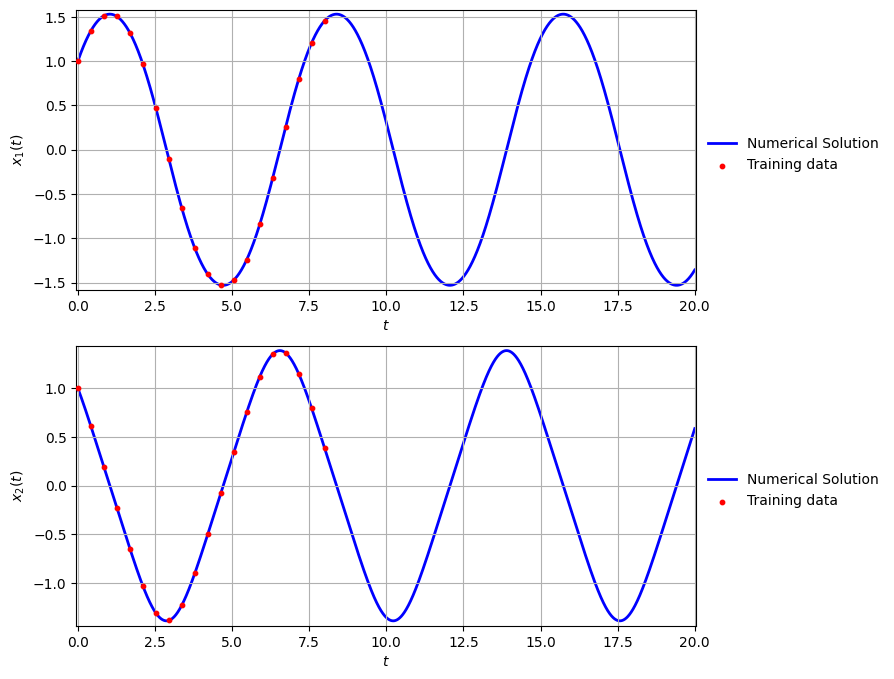

In [156]:
t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution
def ODE(X, t):
    dXdt = [f1(X[0], X[1], t), f2(X[0], X[1], t)]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 20
t_data     = torch.linspace(ti, tf*0.4, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data       = training_data[:,0].view(-1,1)
x2_data       = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 100
t_val        = torch.linspace(ti+0.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val          = validation_data[:,0].view(-1,1)
x2_val          = validation_data[:,1].view(-1,1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(t, x1, label="Numerical Solution", color='blue', lw=2, alpha=1, linestyle='-', zorder=1)
axes[0].scatter(t_data, x1_data, color="red", label="Training data", s=10, zorder=3)
axes[0].set_xlim(ti-.05, tf+0.05)
axes[0].set_ylim(-x1_max-.05, x1_max+0.05)
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$x_1(t)$')
axes[0].legend(frameon=False, loc=(1.01, 0.40))
axes[0].grid()

axes[1].plot(t, x2, label="Numerical Solution", color='blue', lw=2, alpha=1, linestyle='-', zorder=1)
axes[1].scatter(t_data, x2_data, color="red", label="Training data", s=10, zorder=3)
axes[1].set_xlim(ti-.05, tf+0.05)
axes[1].set_ylim(-x2_max-.05, x2_max+0.05)
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x_2(t)$')
axes[1].legend(frameon=False, loc=(1.01, 0.40))
axes[1].grid()

plt.show()

## PINN

In [ ]:
def make_plot():
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    axes[0,0].grid()
    axes[0,0].plot(t, x1, color="gray", linestyle="--", zorder=1, label="Numerical solution")
    axes[0,0].plot(t, p1, color="blue", zorder=2, label="PINN prediction")
    axes[0,0].scatter(t_data, x1_data, color="red", s=10, zorder=3, label="Training data")
    axes[0,0].scatter(t_physics.detach(), 0*torch.ones_like(t_physics.detach()), color="green", s=5, zorder=1, label="Collocation points")
    axes[0,0].set_ylim(-1.05*x1_max, 1.05*x1_max)
    axes[0,0].legend(fontsize="x-small", framealpha=0.5)
    
    axes[1,0].grid()
    axes[1,0].plot(t, x2, color="gray", linestyle="--", zorder=1)
    axes[1,0].plot(t, p2, color="blue", zorder=2)
    axes[1,0].scatter(t_data, x2_data, color="red", s=10, zorder=3)
    axes[1,0].scatter(t_physics.detach(), 0*torch.ones_like(t_physics.detach()), color="green", s=5, zorder=1)
    axes[1,0].set_ylim(-1.05*x2_max, 1.05*x2_max)
    
    axes[0,1].plot(error1_history, label="Error in x1", color="red")
    axes[0,1].plot(error2_history, label="Error in x2", color="blue")
    axes[0,1].set_yscale("log")
    axes[0,1].set_ylim(1e-7, 1e2)
    axes[0,1].set_xlim(0, epochs)
    axes[0,1].grid()
    axes[0,1].legend(fontsize="x-small", framealpha=0.5)
    
    axes[1,1].plot(training_losses, label="training loss", color="red",)
    axes[1,1].plot(validation_losses, label="validation loss", color="blue")
    axes[1,1].plot(physics_losses, label="Training physics loss", color="green", alpha=0.7)
    axes[1,1].plot(data_losses, label="Training data loss", alpha=0.7)
    axes[1,1].plot(derivative_losses, label="derivative loss", alpha=0.7)
    axes[1,1].set_yscale("log")
    axes[1,1].set_ylim(1e-7, 1e2)
    axes[1,1].set_xlim(0, epochs)
    axes[1,1].grid()
    axes[1,1].legend(fontsize="x-small", framealpha=0.5)
    
    
    plt.tight_layout()

In [158]:
learning_rate = 5e-3
gamma         = 0.85
epochs        = 30_000 + 1
w_data        = 1
w_derivative  = 0.1
w_ode         = 0.5

N_phys        = 100

N_layers = 3
N_nodes  = 32

In [159]:
# Define Neural Network Structure

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.scale = lambda t: (t - ti)/(tf - ti)
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [160]:
# Define the sample locations for physics loss

t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

0


/var/folders/7s/hfglvv7s0lzf9snm5f9tjrgrz61syg/T/ipykernel_22269/342863277.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,0].legend()


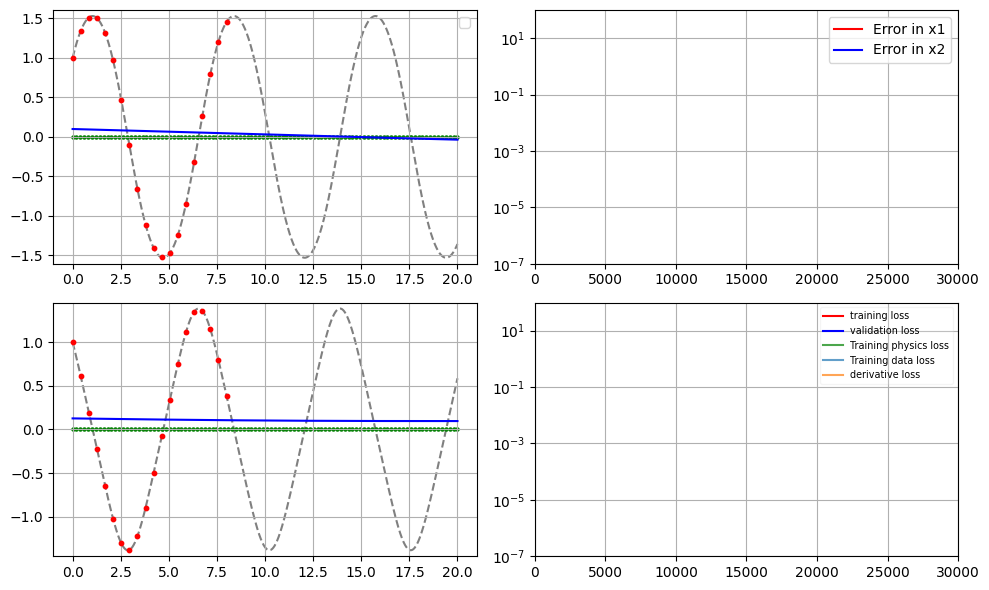

100
200
300
400
500
600
700


KeyboardInterrupt: 

In [161]:
# PINN
torch.manual_seed(123)


PINN = FCN(1, 2, N_nodes, N_layers)

# Optimizer and scheduler
optimizer = torch.optim.Adam(PINN.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

# stores loss values
training_losses, validation_losses = [], []
physics_losses, data_losses, derivative_losses = [], [], []
validation_data_losses, validation_derivative_losses = [], []
error1_history, error2_history = [], []

torch.autograd.set_detect_anomaly(False)
for i in range(epochs):
    # ===
    # Training
    # ===
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss for value
    U  = PINN(t_training)
    u1 = U[:,0].view(-1,1)
    u2 = U[:,1].view(-1,1)
    data_loss = torch.mean((u1 - x1_data)**2 + (u2 - x2_data)**2)
    
    # Compute data loss for derivative
    du1 = torch.autograd.grad(u1, t_training, torch.ones_like(u1), create_graph=True, retain_graph=True)[0]
    du2 = torch.autograd.grad(u2, t_training, torch.ones_like(u2), create_graph=True, retain_graph=True)[0]
    derivative_loss = torch.mean((du1 - f1(x1_data,x2_data,t_training))**2 + (du2 - f2(x1_data,x2_data,t_training))**2)
    
    # Compute the ODE loss
    V   = PINN(t_physics)
    v1  = V[:,0].view(-1,1)
    v2  = V[:,1].view(-1,1)
    dv1 = torch.autograd.grad(v1, t_physics, torch.ones_like(v1), create_graph=True)[0]
    dv2 = torch.autograd.grad(v2, t_physics, torch.ones_like(v2), create_graph=True)[0]
    loss_ODE = torch.mean((dv1 - f1(v1,v2,t_physics))**2 + (dv2 - f2(v1,v2,t_physics))**2)
    
    # Compute total loss
    loss = data_loss + w_derivative*derivative_loss + w_ode*loss_ODE
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    if (i+1) % 1000 == 0: scheduler.step()

    # ===
    # Validation
    # ===
    PINN.eval()

    U_val  = PINN(t_validation)
    u1_val = U_val[:,0].view(-1,1)
    u2_val = U_val[:,1].view(-1,1)
    loss_value_val = torch.mean((u1_val - x1_val)**2 + (u2_val - x2_val)**2)

    du1_val = torch.autograd.grad(u1_val, t_validation, torch.ones_like(u1_val), create_graph=True)[0]
    du2_val = torch.autograd.grad(u2_val,  t_validation, torch.ones_like(u2_val),  create_graph=True)[0]
    loss_derivative_val = torch.mean((du1_val - f1(x1_val, x2_val, t_validation))**2 + (du2_val - f2(x1_val, x2_val, t_validation))**2)
    
    loss_val = loss_value_val + w_derivative*loss_derivative_val
   
    # ===
    # Save performance data
    # ===
    
    P  = PINN(t).detach()
    p1 = P[:,0].view(-1,1)
    p2 = P[:,1].view(-1,1)
    err1 = torch.mean((p1 - x1.view(-1,1))**2)
    err2 = torch.mean((p2 - x2.view(-1,1))**2)
    error1_history.append(err1.item())
    error2_history.append(err2.item())
    training_losses.append(loss.item())
    validation_losses.append(loss_val.item())
    data_losses.append(data_loss.item())
    derivative_losses.append(derivative_loss.item())
    physics_losses.append(loss_ODE.item())
    validation_data_losses.append(loss_value_val.item())
    validation_derivative_losses.append(loss_derivative_val.item() * w_derivative)
    
    # ===
    # Plotting
    # ===
    if (i%100) == 0: print(i)
    if (i % 1_000) == 0: 
        make_plot()
        plt.show()
        if i == (epochs-1):
            plt.savefig(f"plots/pinn_ode_solution_{w0:.2f}.png", dpi=300)
            plt.show()
        elif (i % 5_000) == 0:
            plt.show()
        else: 
            plt.close("all")

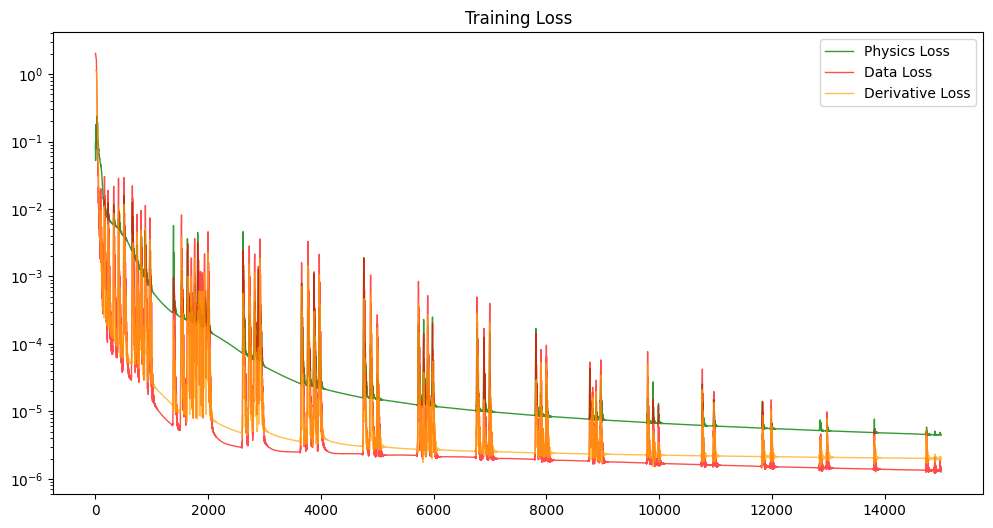

In [ ]:
plt.subplots(figsize=(12,6))
plt.plot(np.arange(epochs), physics_losses, label="Physics Loss", color='green', lw=1, alpha=0.8, linestyle = '-')
plt.plot(np.arange(epochs), l2*torch.tensor(data_losses), label="Data Loss", color='red', lw=1, alpha=0.7)
plt.plot(np.arange(epochs), l1*torch.tensor(derivative_losses), label="Derivative Loss", color='orange', lw=1, alpha=0.7)
plt.title("Training Loss")
plt.legend()
plt.yscale('log')
plt.savefig('loss.png')
plt.show()